# Data Driven Quadrature Tutorial

### by Neal Ma

Welcome! This python notebook shows an example of how to use the data driven quadrature package. Here we generate synthetic data, define appropriate cost and mapping functions, and show the results of this toy-box optimization problem.

In [1]:
# import libraries
import numpy as np
import xarray as xr
import cvxpy as cp
import datadrivenquadrature as ddq

# not required but for visualization
import matplotlib.pyplot as plt

#### Define functions for data generation

In this example, we use a piece-wise function in our data. The function is defined as:

$$f(x) = \left\{
\begin{array}{ll}
    \frac{idx_{x}}{16}(x)(x - 8) \\
    \frac{idx_{y}}{4}(x-8)(x-12)
\end{array}
\right. $$

where $idx_x$ and $idx_y$ are parameters we use to vary the defined spectra across the our dataframe. These are two downward facing parabolas centered at $x=4$ and $x=10$ with roots at $x=0, 8, 12$. We use a range $0 \leq x \leq 12$ which allows us to find a closed form solution for the integral as:

$$\begin{align*}
    V = \int_{0}^{12} f(x) = \frac{16}{3} idx_x + \frac{8}{3} idx_y
\end{align*}$$

In [2]:
def user_function(x, x_idx, y_idx):
    # comment out below this line if you would like to test your own function
    val = 0
    if x < 8:
        val = (-x_idx / 16.) * (x) * (x - 8)
    else:
        val = (-y_idx / 4.) * (x - 8) * (x - 12)
    return val

def generate_spectra(x_idx, y_idx, x_min, x_max, s=1000):
    spectra = []
    x = np.arange(x_min, x_max, 1./s)
    for val in x:
        spectra.append(user_function(val, x_idx, y_idx))
    return spectra

def compute_exact_integral(x, x_idx, y_idx, s):
    # exact closed-form solution of example function above
    return 16./3 * x_idx + 8./3 * y_idx
    # comment above and uncomment below if using your own non-closed form function
    # return sum(x) / s

We can visualize this spectra for $idx_x = 2, idx_y = 4$:

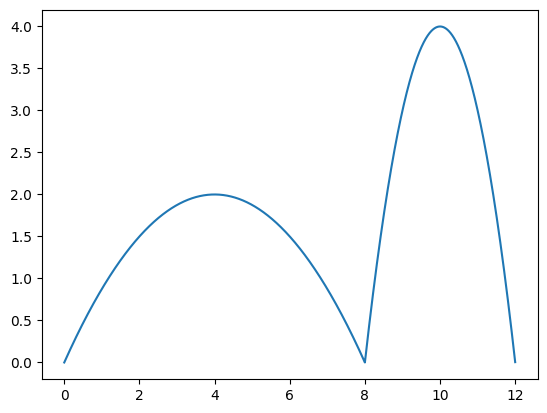

In [3]:
graph_spectra = generate_spectra(2, 4, 0, 12, s=1000)
x = np.arange(0, 12, 1/1000.)
plt.plot(x, graph_spectra)

#### Build dataset for optimization

Here, we generate data to use for the optimization. We define a 10 by 10 grid of spectra where the x index ($idx_x$) and y index ($idx_y$) of the spectra within the dataset are used as parameters for parabola heights (see function definition above).

In [4]:
n = 10 # size of square block of data
s = 1000 # reciprocal step size of the integration axis

# initialize empty arrays to hold synthetic data
x_integrated = []
x_spectra = []

# generate and store synthetic data
for y_idx in range(n):
    x_integrated_row = []
    x_spectra_row = []
    for x_idx in range(n):
        x_spectra_row.append(generate_spectra(x_idx + 1, y_idx + 1, 0, 12, s))
        x_integrated_row.append(compute_exact_integral(x_spectra_row[-1], x_idx + 1, y_idx + 1, s))
    x_integrated.append(x_integrated_row)
    x_spectra.append(x_spectra_row)

# generate integration axis 
x_range = np.arange(0, 12, 1./s)

# store synthetic data in a xarray data array
x = xr.DataArray(x_spectra,
    dims=("x_idx", "y_idx", "integration_axis"), 
    coords={"x_idx": list(np.arange(1, n + 1, 1)),
             "y_idx": list(np.arange(1, n + 1, 1)),
             "integration_axis": x_range}
)

# store pre-calculated integrals; not necessary but can just for good record keeping
y = xr.DataArray(x_integrated,
    dims=("x_idx", "y_idx"), 
    coords={"x_idx": list(np.arange(1, n + 1, 1)),
             "y_idx": list(np.arange(1, n + 1, 1))}
)

# extract the reference values in a flattened array
y_ref = y.values.flatten()

In [7]:
# number of integration points to use
n_integration_points = 12

# user defined cost function using only built-in cvxpy functions
def user_cost_fnc(y, y_hat):
    cost = cp.norm(y - y_hat)
    return cost

# user defined mapping function that returns 
def map_func(x, point_set, x_sup=None):
    # extract point indices from the point set
    point_idxs = [point for point in point_set]
    # extract point vector and return in matrix of shape (# spectra, # integration points)
    points = np.array(x[:,:,point_idxs].values).reshape((n*n, n_integration_points))
    return points

# define parameters for optimization
params = {}
integration_list = ['integration_axis']
params['integration_list'] = integration_list # REQUIRED
params['n_points'] = n_integration_points # REQUIRED
params['epochs'] = 250 # OPTIONAL
params['success'] = 25 # OPTIONAL
params['block_size'] = 50 # OPTIONAL
params['random_seed'] = 1 # OPTIONAL
params['verbose'] = 2 # OPTIONAL

# run the optimization and safe the history dictionary
# NOTE: y_ref must be normalized to an integration axis of length 1, so we divide y_ref by 12 (length of integration axis)
history = ddq.optimize(x, y_ref / 12, user_cost_fnc, map_func, params, x_sup=None)

EPOCH: 1	AVG COST: 1.823e-10	BEST COST: 4.510e-12
EPOCH: 2	AVG COST: 1.635e-10	BEST COST: 4.510e-12
EPOCH: 3	AVG COST: 9.177e-11	BEST COST: 4.510e-12


c:\Python311\Lib\site-packages\datadrivenquadrature\main.py:151: RuntimeWarning: overflow encountered in exp
  return np.exp((last_cost - current_cost)/T)


EPOCH: 4	AVG COST: 4.415e-02	BEST COST: 4.510e-12
EPOCH: 5	AVG COST: 1.146e-10	BEST COST: 4.510e-12
EPOCH: 6	AVG COST: 1.083e-10	BEST COST: 4.510e-12
EPOCH: 7	AVG COST: 1.022e-10	BEST COST: 7.892e-13
EPOCH: 8	AVG COST: 2.467e-01	BEST COST: 7.892e-13
EPOCH: 9	AVG COST: 2.355e-10	BEST COST: 7.892e-13
EPOCH: 10	AVG COST: 1.640e-10	BEST COST: 7.892e-13
EPOCH: 11	AVG COST: 8.658e-11	BEST COST: 7.892e-13
EPOCH: 12	AVG COST: 7.892e-11	BEST COST: 7.892e-13
EPOCH: 13	AVG COST: 6.625e-11	BEST COST: 6.911e-13
EPOCH: 14	AVG COST: 2.592e-10	BEST COST: 6.911e-13
EPOCH: 15	AVG COST: 2.437e-10	BEST COST: 6.911e-13
EPOCH: 16	AVG COST: 1.810e-10	BEST COST: 6.911e-13
EPOCH: 17	AVG COST: 3.281e-01	BEST COST: 6.911e-13
EPOCH: 18	AVG COST: 8.815e-11	BEST COST: 6.911e-13
EPOCH: 19	AVG COST: 7.991e-11	BEST COST: 6.911e-13
EPOCH: 20	AVG COST: 1.192e-10	BEST COST: 6.911e-13
EPOCH: 21	AVG COST: 1.271e-10	BEST COST: 6.911e-13
EPOCH: 22	AVG COST: 1.724e-10	BEST COST: 6.911e-13
EPOCH: 23	AVG COST: 1.832e-01	BEST CO

dict_keys(['cost', 'point_sets', 'weight_sets', 'temperature_history', 'best'])
(214, 26)
2.9699767020102814e-13
[7229, 940, 11870, 602, 2907, 3116, 9228, 1633, 5906, 8859, 9746, 2615]
[0.0786402  0.08035486 0.07823131 0.07660094 0.08752224 0.08779506
 0.08465984 0.08446089 0.08591344 0.08312223 0.08564984 0.08704915]


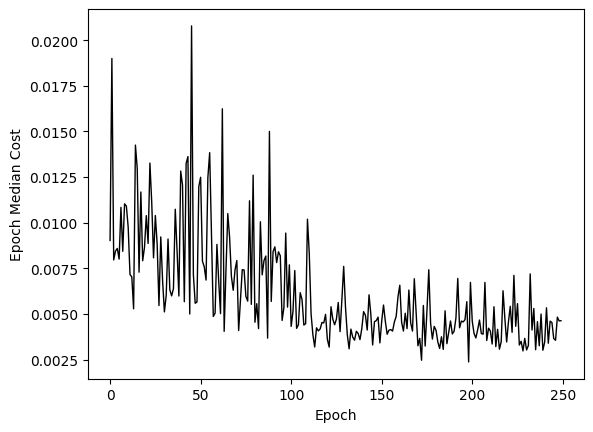

In [8]:
# calculate mean and median costs for each block
mean_costs = []
median_costs = []
for cost in history['cost']:
    mean_costs.append(np.mean(cost))
    median_costs.append(np.median(cost)*1e8)

# plot median costs and print best point set, weights, and associated cost
plt.plot(np.arange(len(median_costs)), median_costs, color='black', linewidth=1)
plt.xlabel('Epoch')
plt.ylabel('Epoch Median Cost')
# plt.title('Median Cost per Epoch')
best = history['best']
print(history.keys())
print(best)
print(history['cost'][best[0]][best[1]])
print(history['point_sets'][best[0]][best[1]])
print(history['weight_sets'][best[0]][best[1]])

Note that because this is a relatively simple example, we see an extremely low cost achieved very quickly and the median cost does not significantly decrease over time. For a more realistic example, see the atmospheric energy flux exmaple in <code>example.ipynb</code>.